In [1]:
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt
#%matplotlib inline

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy import select, func
from sqlalchemy import or_, and_

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from db_scripts.brewbrain_db import BREWBRAIN_DB_ENGINE_STR, Base, CoreStyle, Style, Hop, Grain, Adjunct, Misc, Microorganism, RecipeML, RecipeMLGrainAT, RecipeMLHopAT, RecipeMLAdjunctAT, RecipeMLMiscAT

In [2]:
engine = create_engine(BREWBRAIN_DB_ENGINE_STR, echo=False, future=True)
Base.metadata.create_all(engine)

'''
fig = plt.figure(figsize=(20,500))

with Session(engine) as session:
  # Grab each available style
  styles = session.scalars(select(Style).group_by(Style.id)).all()

  mashph_means = np.zeros((len(styles)), dtype=np.float32)
  mashph_vars  = np.zeros_like(mashph_means)

  num_plots = len(styles)
  side_x_num = 6
  side_y_num = num_plots // side_x_num
  plot_x = 0
  plot_y = 0

  for i, style in enumerate(styles):
    # For each style we want to see the data distributions... 
    # mean, variation etc. for key attributes of the recipe
    recipes = session.scalars(select(RecipeML).filter_by(style=style)).all()
    
    mashphs       = np.zeros((len(recipes)), dtype=np.float32)
    mash_temps    = np.zeros_like(mashphs)
    ferment_temps = np.zeros_like(mashphs)

    for j, recipe in enumerate(recipes):
      mashphs[j] = float(recipe.mash_ph)

      for k in range(1,recipe.num_mash_steps+1):
        stepstr_prefix = "mash_step_"+str(k)
        #if getattr(recipe, stepstr_prefix+"_type") == "infusion":
        mash_temps[j] = max(mash_temps[j], float(getattr(recipe, stepstr_prefix + "_start_temp")))

      for k in range(1, recipe.num_ferment_stages+1):
        stepstr_prefix = "ferment_stage_"+str(k)
        ferment_temps[j] = max(ferment_temps[j], float(getattr(recipe, stepstr_prefix + "_temp")))

    if len(recipes) != 0:
      ax = fig.add_subplot(side_y_num, side_x_num, plot_x + 1 + plot_y*side_x_num)
      ax.set_title(style.name)
      ax.hist(ferment_temps, bins=50)
      #print(f"[{style.name}]: <Mash pH - Mean: {mashphs.mean()}, Var: {mashphs.var()}>")

    plot_x += 1
    if plot_x >= side_x_num:
      plot_x = 0
      plot_y += 1

  #session.scalars(select(RecipeML).filter_by(hash=recipe_ml.hash)).first()

fig.suptitle("Fermentation Temperatures (C)", y=1.0)
fig.tight_layout(pad=1.0)
plt.show()
'''

'\nfig = plt.figure(figsize=(20,500))\n\nwith Session(engine) as session:\n  # Grab each available style\n  styles = session.scalars(select(Style).group_by(Style.id)).all()\n\n  mashph_means = np.zeros((len(styles)), dtype=np.float32)\n  mashph_vars  = np.zeros_like(mashph_means)\n\n  num_plots = len(styles)\n  side_x_num = 6\n  side_y_num = num_plots // side_x_num\n  plot_x = 0\n  plot_y = 0\n\n  for i, style in enumerate(styles):\n    # For each style we want to see the data distributions... \n    # mean, variation etc. for key attributes of the recipe\n    recipes = session.scalars(select(RecipeML).filter_by(style=style)).all()\n    \n    mashphs       = np.zeros((len(recipes)), dtype=np.float32)\n    mash_temps    = np.zeros_like(mashphs)\n    ferment_temps = np.zeros_like(mashphs)\n\n    for j, recipe in enumerate(recipes):\n      mashphs[j] = float(recipe.mash_ph)\n\n      for k in range(1,recipe.num_mash_steps+1):\n        stepstr_prefix = "mash_step_"+str(k)\n        #if getatt

In [34]:
def query_values(column_names):
  values = []
  for column_name in column_names:
    values +=  session.query(column_name).all()
  values = np.array(values, dtype=np.float32).squeeze(1)
  return values[values != np.array(None)]

# Determine the distributions of all major values in recipes
with Session(engine) as session:
  mash_step_times = query_values([
    RecipeML.mash_step_1_time, RecipeML.mash_step_2_time, RecipeML.mash_step_3_time, 
    RecipeML.mash_step_4_time, RecipeML.mash_step_5_time, RecipeML.mash_step_6_time
  ])
  mash_step_temps = query_values([
    RecipeML.mash_step_1_start_temp, RecipeML.mash_step_2_start_temp, RecipeML.mash_step_3_start_temp, 
    RecipeML.mash_step_4_start_temp, RecipeML.mash_step_5_start_temp, RecipeML.mash_step_6_start_temp,
    RecipeML.mash_step_1_end_temp, RecipeML.mash_step_2_end_temp, RecipeML.mash_step_3_end_temp, 
    RecipeML.mash_step_4_end_temp, RecipeML.mash_step_5_end_temp, RecipeML.mash_step_6_end_temp,
  ])
  
  print(f"[Mash step times]: min: {np.min(mash_step_times)}, max: {np.max(mash_step_times)}, mean: {np.mean(mash_step_times)}, var: {np.var(mash_step_times)}")
  print(f"[Mash step temps]: min: {np.min(mash_step_temps)}, max: {np.max(mash_step_temps)}, mean: {np.mean(mash_step_temps)}, var: {np.var(mash_step_temps)}")



[Mash step times]: min: 0, max: 180, mean: 44.7646846816359, var: 695.8103352581271
[Mash step temps]: min: 0.0, max: 78.0, mean: 67.65409689364856, var: 52.65084059402701


In [72]:
# Determine the maximum numbers of ingredient types across all recipes, find outliers
with Session(engine) as session:

  grain_count_q   = session.query(RecipeML.id, func.count(RecipeMLGrainAT.id)).outerjoin(RecipeMLGrainAT).group_by(RecipeML.id).all()
  hop_count_q     = session.query(RecipeML.id, func.count(RecipeMLHopAT.id)).outerjoin(RecipeMLHopAT).group_by(RecipeML.id).all()
  adjunct_count_q = session.query(RecipeML.id, func.count(RecipeMLAdjunctAT.id)).outerjoin(RecipeMLAdjunctAT).group_by(RecipeML.id).all()
  misc_count_q    = session.query(RecipeML.id, func.count(RecipeMLMiscAT.id)).outerjoin(RecipeMLMiscAT).group_by(RecipeML.id).all()

  #grain_count_q.sort(key=lambda x: x[1], reverse=True)
  #hop_count_q.sort(key=lambda x: x[1], reverse=True)
  #adjunct_count_q.sort(key=lambda x: x[1], reverse=True)
  #print(adjunct_count_q)
  
  grain_counts   = [n[1] for n in grain_count_q]
  hop_counts     = [n[1] for n in hop_count_q]
  adjunct_counts = [n[1] for n in adjunct_count_q]
  misc_counts    = [n[1] for n in misc_count_q]

  print(f"Max grains in a recipe:   {max(grain_counts)}")
  print(f"Max hops in a recipe:     {max(hop_counts)}")
  print(f"Max adjuncts in a recipe: {max(adjunct_counts)}")
  print(f"Max misc. in a recipe:    {max(misc_counts)}")
  print("----------------------------------------")

  # Max fermentation and mash stages
  mash_steps     = session.query(RecipeML.id, RecipeML.num_mash_steps).all()
  ferment_stages = session.query(RecipeML.id, RecipeML.num_ferment_stages).all()
  
  mash_steps.sort(key=lambda x: x[1], reverse=True)
  ferment_stages.sort(key=lambda x: x[1], reverse=True)

  #print(mash_steps)
  print(f"Max mash steps:     {mash_steps[0][1]}")
  print(f"Max ferment stages: {ferment_stages[0][1]}")

  # How many unique types are there for each ingredient?
  num_grains = session.query(Grain).count()
  print(f"Number of unique grains:   {num_grains}")
  num_hops = session.query(Hop).count()
  print(f"Number of unique hops:     {num_hops}")
  num_adjuncts = session.query(Adjunct).count()
  print(f"Number of unique adjuncts: {num_adjuncts}")
  num_miscs = session.query(Misc).count()
  print(f"Number of unique miscs:    {num_miscs}")
  print("----------------------------------------")

  act_num_grains_used = session.query(RecipeMLGrainAT.grain_id).group_by(RecipeMLGrainAT.grain_id).count()
  print(f"Actual number of grains used: {act_num_grains_used}")
  act_num_hops_used = session.query(RecipeMLHopAT.hop_id).group_by(RecipeMLHopAT.hop_id).count()
  print(f"Actual number of hops used:   {act_num_hops_used}")
  print("----------------------------------------")

  # What stages exist for various ingredients?
  hop_stages = session.query(RecipeMLHopAT.stage).group_by(RecipeMLHopAT.stage).all()
  print(f"Hop stages: {hop_stages}")
  misc_stages = session.query(RecipeMLMiscAT.stage).group_by(RecipeMLMiscAT.stage).all()
  print(f"Misc. stages: {misc_stages}")

Max grains in a recipe:   15
Max hops in a recipe:     32
Max adjuncts in a recipe: 8
Max misc. in a recipe:    19
----------------------------------------
Max mash steps:     6
Max ferment stages: 2
Number of unique grains:   1113
Number of unique hops:     355
Number of unique adjuncts: 363
Number of unique miscs:    127
----------------------------------------
Actual number of grains used: 732
Actual number of hops used:   272
----------------------------------------
Hop stages: [('aroma',), ('boil',), ('dry hop',), ('first wort',), ('mash',)]
Misc. stages: [('boil',), ('bottling',), ('mash',), ('primary',), ('secondary',)]


In [ ]:
# Find the number of times each grain, hop, etc. appears in a particular style
with Session(engine) as session:
  # Grains
  grains_style_map = {}
  grains_style_sets = {}
  grain_ids = session.scalars(select(Grain.id)).all()
  style_ids = session.scalars(select(CoreStyle.id)).all()
  for id in grain_ids:
    grains_style_map[id]  = {s: 0 for s in style_ids}
    grains_style_sets[id] = set()

  style_to_grain = session.query(CoreStyle.id, RecipeMLGrainAT.grain_id) \
    .join(Style, Style.core_style_id == CoreStyle.id) \
    .join(RecipeML, RecipeML.style_id == Style.id) \
    .join(RecipeMLGrainAT, RecipeMLGrainAT.recipe_ml_id == RecipeML.id) \
    .all()
  for stg in style_to_grain:
    grains_style_map[stg[1]][stg[0]] = 1
    grains_style_sets[stg[1]].add(stg[0])

  # Hops
  hop_ids = session.scalars(select(Hop.id)).all()
  hops_style_map  = {}
  hops_style_sets = {}
  for id in hop_ids:
    hops_style_map[id]  = {s: 0 for s in style_ids}
    hops_style_sets[id] = set()

  style_to_hop = session.query(CoreStyle.id, RecipeMLHopAT.hop_id) \
    .join(Style, Style.core_style_id == CoreStyle.id) \
    .join(RecipeML, RecipeML.style_id == Style.id) \
    .join(RecipeMLHopAT, RecipeMLHopAT.recipe_ml_id == RecipeML.id) \
    .all()
  for sth in style_to_hop:
    hops_style_map[sth[1]][sth[0]] = 1
    hops_style_sets[sth[1]].add(sth[0])

def style_counts_for_grain(grain_id):
  return [style_count for style_count in grains_style_map[grain_id].values()]
#def style_

#for grain_id in grain_ids: print(style_counts_for_grain(grain_id[0]))







# List all of the styles that are actually used across all recipes
#used_styles = set()
#for style_set in grains_style_sets.values():
#  used_styles = used_styles.union(style_set)
#print(len(used_styles)) # These are the 'core' styles that are actually used across all recipes


(1112, 3)


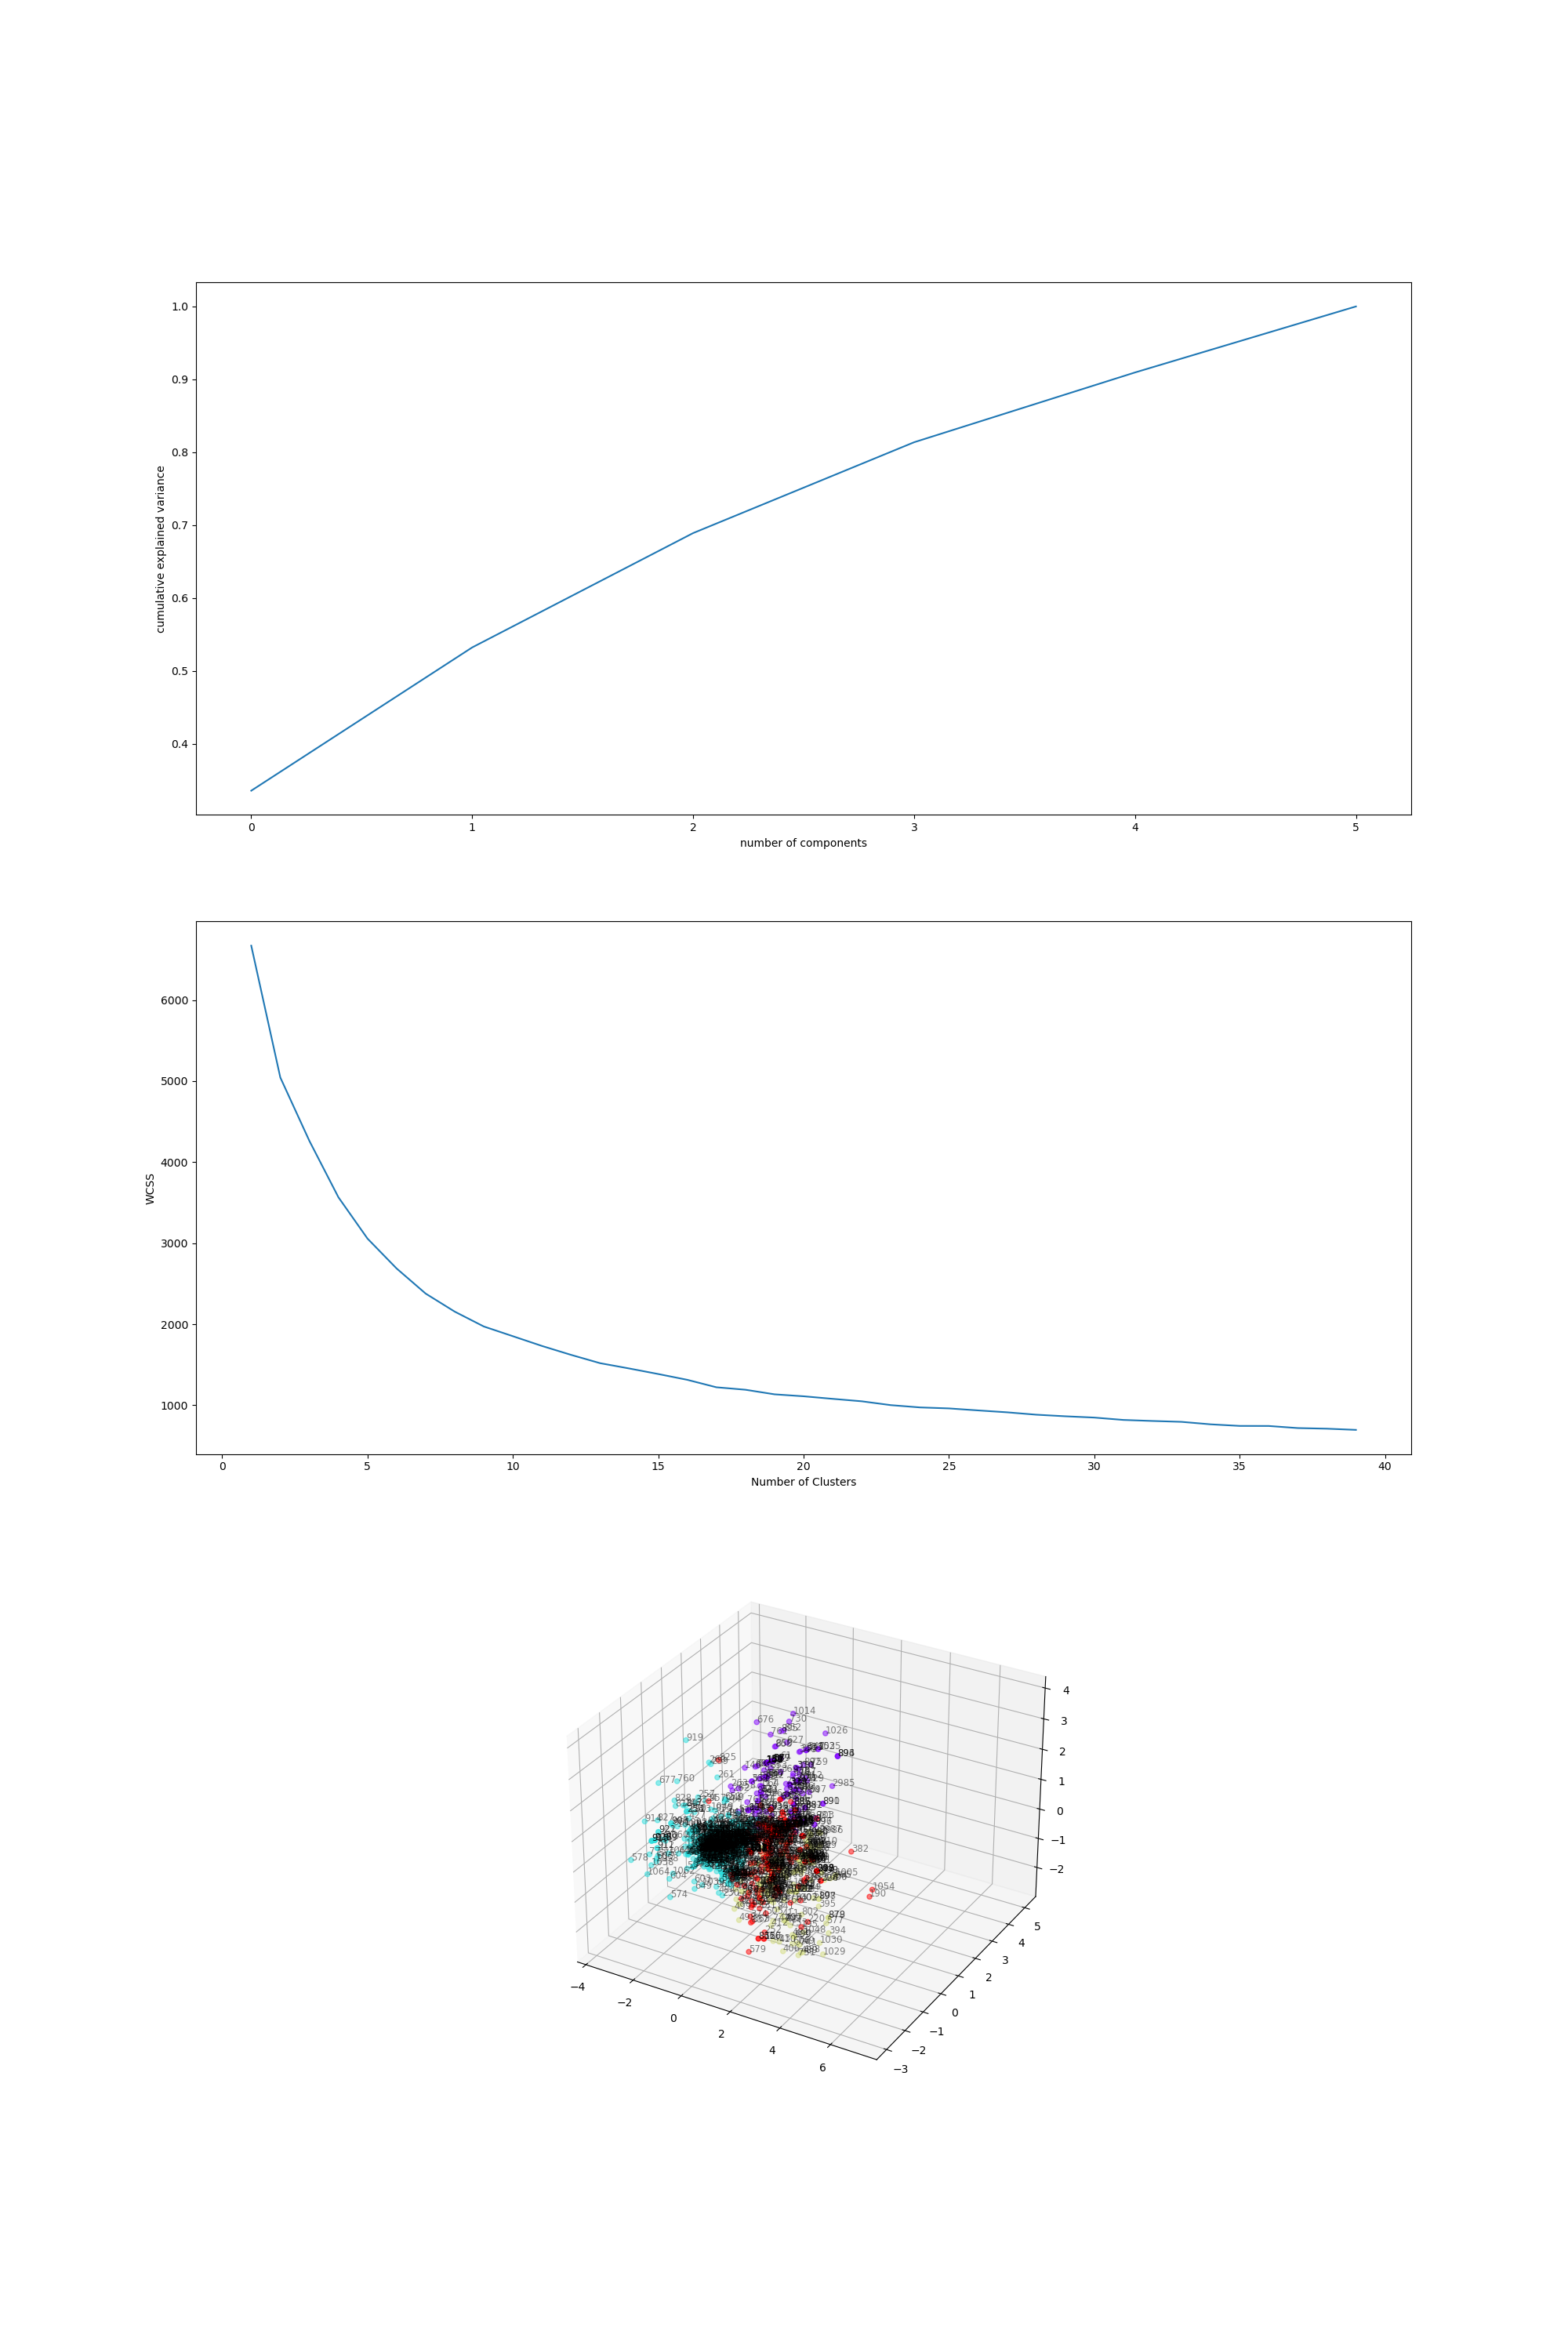

In [67]:
# PCA on malts **************************************

with Session(engine) as session:
  # Gather up all our malts/grains
  malts_db = session.scalars(select(Grain).filter(Grain.is_fermentable == 1)).all()
  malt_names = [malt.name for malt in malts_db]
  malt_arr   = [[malt.colour_srm, malt.moisture, malt.coarse_fine_diff, malt.protein, malt.diastatic_power, malt.dbfg] for malt in malts_db]
  malt_A     = np.array(malt_arr)
  #print(pd.DataFrame(malt_A, columns=malt_props)) # Show the table of malts

  scaler = StandardScaler()
  scaler.fit_transform(malt_A)

  #print(scaler.mean_)
  #print(np.sqrt(scaler.var_))
  #print(scaler.transform(malt_A))
  malt_A_n = scaler.transform(malt_A)
  malt_pca = PCA(n_components=3)
  malt_pcs = malt_pca.fit_transform(malt_A_n)
  print(malt_pcs.shape)
  #print(malt_pca.explained_variance_)
  #print(pd.DataFrame(data=malt_pcs, columns=["PC1", "PC2"]))

  fig = plt.figure(figsize=(20,30))
  #ax = fig.add_subplot(4,1,1,projection='3d')
  #ax.scatter(malt_pcs[:,0], malt_pcs[:,1], malt_pcs[:,2], alpha=0.5)
  #ax.set_xlabel("component 1")
  #ax.set_ylabel("component 2")
  #ax.set_zlabel("component 3")
  
  pca = PCA().fit(malt_A_n)
  ax2 = fig.add_subplot(3,1,1)
  ax2.plot(np.cumsum(pca.explained_variance_ratio_))
  ax2.set_xlabel('number of components')
  ax2.set_ylabel('cumulative explained variance');
  
  wcss = [] # Within-Cluster-Sum-of-Squares
  for i in range(1,40):
    kmeans = KMeans(i)
    kmeans.fit(malt_A_n)
    wcss.append(kmeans.inertia_)
  ax3 = fig.add_subplot(3,1,2)
  ax3.plot(range(1,40), wcss)
  ax3.set_xlabel("Number of Clusters")
  ax3.set_ylabel("WCSS")

  #malt_pca2 = PCA(n_components=2)
  #malt_pcs = malt_pca2.fit_transform(malt_A_n)
  kmeans = KMeans(n_clusters=4, init='k-means++')
  clusters = kmeans.fit_predict(malt_pcs)
  ax4 = fig.add_subplot(3,1,3,projection='3d')
  ax4.scatter(malt_pcs[:,0], malt_pcs[:,1], malt_pcs[:,2], alpha=0.5, c=clusters, cmap='rainbow')
  
  for i,malt in enumerate(malts_db):
    #dist = np.sqrt(malt_pcs[i,0]**2 + malt_pcs[i,1]**2 + malt_pcs[i,2]**2)
    #if dist > 3 and i % 10 == 0:
    ax4.text(malt_pcs[i,0], malt_pcs[i,1], malt_pcs[i,2], str(malt.id), fontsize='smaller', alpha=0.5)

  plt.show()



In [23]:
# Inputs:

# Malt bill (16 slots):
# - % of each malt in the bill [float: [0,1]]
# - type [Categorical: 732 classes] TODO: Clean this up into a smaller space (there are a lot of repeats across suppliers), Embed to a smaller dimension (NOTE: ~128 dimensions)

# Hops (32 slots):
# - stage [('aroma',), ('boil',), ('dry hop',), ('first wort',), ('mash',)] [Categorical: 5 classes] - One-hot encoded
# - quantity - either in IBUs (for aroma, boil, first wort) or g/L (for mash, dry hop) [normalized float]
# - time - in minutes [normalized float?]
# - type [Categorical: 272 classes] TODO: Embed to a smaller dimension (~96)

# Adjuncts (8 slots):
# - stage [('boil',), ('bottling',), ('mash',), ('primary',), ('secondary',)] [Categorical: 5 classes] - One-hot encoded
# - quantity (in kgs or mls) [normalized float]
# - type [Categorical: 334 classes] TODO: Embed to a smaller dimension (~128)

# Misc (16 slots):
# - Group together all nutrients, ignore superfluous types (water agents except when used in large quantities... figure that out.)
# - quantity (in kgs/mls) [normalized float]
# - stage [('boil',), ('bottling',), ('mash',), ('primary',), ('secondary',)] [Categorical: 5 classes] - One-hot encoded
# - type [Categorical: 127 classes], embed to a smaller dimension, likely related to type... probably 32 or 64

# Mash Stages (6 slots):
# - type ['infusion', 'temperature', 'decoction'] [Categorical: 3 classes] - One-hot encoded
# - time (in mins) [normalized float]
# - temperature (in C) [normalized float]
# - water quantity (in L) [normalized float]

# Fermentation Stages (2 slots):
# - time (in days) [normalized float]
# - temperature (in C) [normalized float]

16*(1+128) + 32*(5+1+1+96) + 8*(5+1+128) + 16*(1+5+64) + 6*(3+1+1+1) + 2*(1+1)


2064